# Amazon stock price prediction using Machine learning with Time Series analysis

It is very difficult to predict the way stock market behaves. One good way to look at it is analyzing the historical data associated and predict future trends. But there are so many other factors that impact a stock price - market sentiments, boards financial decisions, geographical locations and nowadays social media interaction via Twitter etc. 

This means that there are no consistent patterns in the data that allow you to model stock prices over time near-perfectly. 
A very famous economist from Princeton University, Burton Malkiel, once mentioned in his book "A Random Walk Down Wall Street," that if the market is truly efficient and a share price reflects all factors immediately as soon as they're made public, a blindfolded monkey throwing darts at a newspaper stock listing should do as well as any investment professional.

Hpwever, lets not loose our hopes and concentrate on what machine learning can do here to model the data, so that the predictions we make correlate with the actual behavior of the data. 

# Understanding the Problem Statement

We’ll dive into the implementation part of this article soon, but first it’s important to establish what we’re aiming to solve. Broadly, stock market analysis is divided into two parts – Fundamental Analysis and Technical Analysis.

Fundamental Analysis involves analyzing the company’s future profitability on the basis of its current business environment and financial performance.
Technical Analysis, on the other hand, includes reading the charts and using statistical figures to identify the trends in the stock market.
As you might have guessed, our focus will be on the technical analysis part. We’ll be using stock data from macrotrends.com to dive in!

We will first load the dataset, see its structure and define the target variable for the problem:

In [1]:
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('MacroTrends_Data_Download_AMZN.csv')

#print the head
df.head()

,date,open,high,low,close,volume
0,5/16/1997,1.8650,1.9792,1.7083,1.7292,14700000
1,5/19/1997,1.7083,1.7708,1.6250,1.7083,6106800
2,5/20/1997,1.7292,1.7500,1.6358,1.6358,5467200
3,5/21/1997,1.6042,1.6458,1.3750,1.4275,18853200
4,5/22/1997,1.4375,1.4483,1.3125,1.3958,11776800


In [2]:
# Print the tail of df
print(df.tail())

            date     open     high      low    close   volume
5401  10/31/2018  1569.99  1623.91  1565.09  1598.01  9390211
5402   11/1/2018  1623.53  1670.45  1598.44  1665.53  8135539
5403   11/2/2018  1678.59  1697.44  1651.83  1665.53  6955548
5404   11/5/2018  1657.57  1658.09  1596.36  1627.80  5624727
5405   11/6/2018  1618.35  1665.00  1614.55  1642.81  4176813


In [3]:
# Print the shape of df
print(df.shape)

(5406, 6)


In [4]:
# Print the columns of df
print(df.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')


There are multiple variables in the dataset – date, open, high, low, close, and volume.

The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.
High, Low and Last represent the maximum, minimum, and last price of the share for the day.
Total Trade Quantity is the number of shares bought or sold in the day and Turnover (Lacs) is the turnover of the particular company on a given date.
# Now lets do some data wrangling on the data for some additional observations on the data

In [5]:
len(df)

5406

In [6]:
#check for duplicate data on date values
df['date'].nunique()

5406

In [7]:
# Find any NULL values
df.isnull().values.any()

False

### Seems like the data available does not have any NULL values and duplicates. We will see if we find any other data issue while working on it further

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

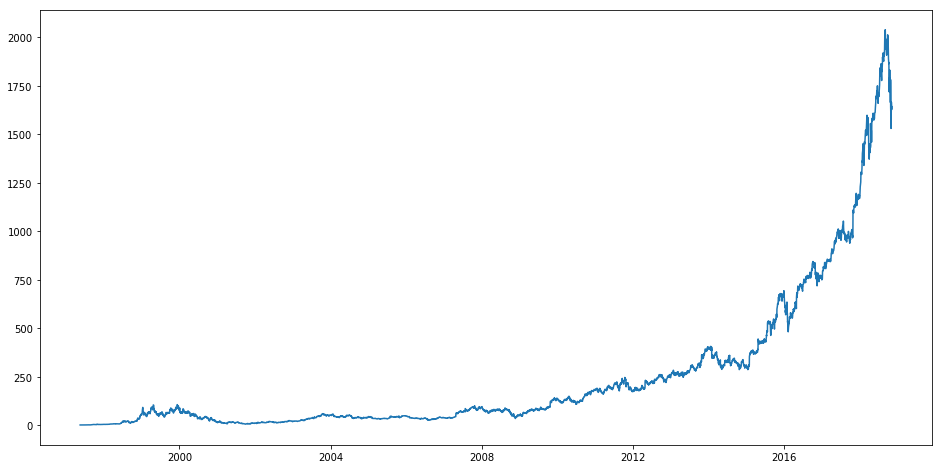

In [8]:
#setting index as date
df['date'] = pd.to_datetime(df.date,format='%m/%d/%Y')
df.index = df['date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Close Price history')

Wow, we a steep incline in the Amazon price after 2016. Some of you would be rich if you were holding the stock since prior 2016. :)
### Anyways, in the next sections, we are going to explore these variables and use different techniques to predict the daily closing stock prices.

# Moving Average

## Introduction

‘Average’ is easily one of the most common things we use in our day-to-day lives. For instance, calculating the average marks to determine overall performance, or finding the average temperature of the past few days to get an idea about today’s temperature – these all are routine tasks we do on a regular basis. So this is a good starting point to use on our dataset for making predictions.

The predicted closing price for each day will be the average of a set of previously observed values. Instead of using the simple average, we will be using the moving average technique which uses the latest set of values for each prediction. In other words, for each subsequent step, the predicted values are taken into consideration while removing the oldest observed value from the set. Here is a simple figure that will help you understand this with more clarity.

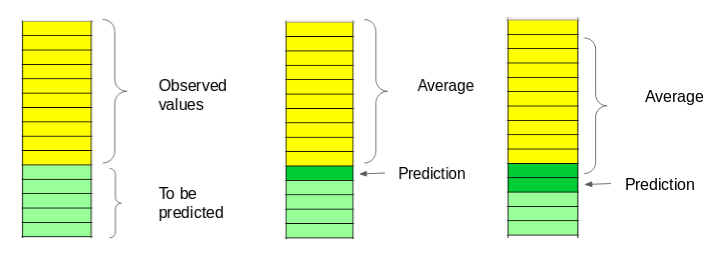

In [9]:
from IPython.display import Image
Image(filename=r"C:/Users/anshu/Downloads/moving_avg.jpeg")

We will implement this technique on our dataset. The first step is to create a dataframe that contains only the date and close price columns, then split it into train and validation sets to verify our predictions.

In [10]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])

for i in range(0,len(data)):
     new_data['date'][i] = data['date'][i]
     new_data['close'][i] = data['close'][i]

In [11]:
print(new_data.head())

                  date   close
0  1997-05-16 00:00:00  1.7292
1  1997-05-19 00:00:00  1.7083
2  1997-05-20 00:00:00  1.6358
3  1997-05-21 00:00:00  1.4275
4  1997-05-22 00:00:00  1.3958


In [12]:
new_data.shape

(5406, 2)

In [13]:
#new_data[4898:]['date'].min()
#splitting into train and validation. Here we are taking last two years of data as test and prior to that as train
train = new_data[:4898]
valid = new_data[4898:]

In [14]:
new_data.shape, train.shape, valid.shape

((5406, 2), (4898, 2), (508, 2))

In [15]:
train['date'].min(), train['date'].max(), valid['date'].min(), valid['date'].max()

(Timestamp('1997-05-16 00:00:00'),
 Timestamp('2016-10-31 00:00:00'),
 Timestamp('2016-11-01 00:00:00'),
 Timestamp('2018-11-06 00:00:00'))

The next step is to create predictions for the validation set and check the RMSE using the actual values.

In [16]:
#make predictions
preds = []
for i in range(0,508):
    a = train['close'][len(train)-508+i:].sum() + sum(preds)
    b = a/508
    preds.append(b)

# Results

In [17]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['close'])-preds),2)))
rms

717.9882259690223

Just checking the RMSE does not help us in understanding how the model performed. Let’s visualize this to get a more intuitive understanding. So here is a plot of the predicted values along with the actual values.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


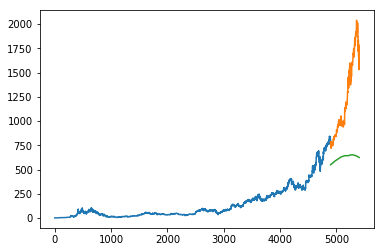

In [18]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

# Inference

The RMSE value is close to 717 and the results are not very promising (as you can gather from the plot). The predicted values are of the same range as the observed values in the train set (there is an increasing trend initially and then a slow decrease).